# 벡터화 실습: 원-핫 인코딩 구현해보기

## Step 1. 패키지 설치하기

In [1]:
# ! pip install koNLPy

In [23]:
import re
from konlpy.tag import Okt
from collections import Counter

In [24]:
text = "임금님 귀는 당나귀 귀! 임금님 귀는 당나귀 귀! 실컷~ 소리치고 나니 속이 확 뚫려 살 것 같았어."
text

'임금님 귀는 당나귀 귀! 임금님 귀는 당나귀 귀! 실컷~ 소리치고 나니 속이 확 뚫려 살 것 같았어.'

## Step 2. 전처리 이야기
- 대개 특수문자들은 자연어 처리에서 큰 의미를 가지지 못한다. 
- 한글과 공백을 제외하고 특수문자만 제거하고 싶다면 어떤 정규 표현식을 사용하면 될까? 
- 정규 표현식으로 한국어의 범위를 지정할 수 있어야 한다.

In [25]:
# 정규 표현식을 반영하여 전처리 수행 

reg = re.compile("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]")
text = reg.sub('', text)
print(text)

임금님 귀는 당나귀 귀 임금님 귀는 당나귀 귀 실컷 소리치고 나니 속이 확 뚫려 살 것 같았어


! , ~ , . 가 제거되었다.

## Step 3. 토큰화 이야기
- 단어장을 구성하기 위해서는 단어장의 원소인 토큰(token)이라는 단위를 정해줘야 한다. 

In [26]:
okt=Okt()
tokens = okt.morphs(text)
print(tokens)

['임금님', '귀', '는', '당나귀', '귀', '임금님', '귀', '는', '당나귀', '귀', '실컷', '소리', '치고', '나니', '속이', '확', '뚫려', '살', '것', '같았어']


## Step 4. 단어장 만들기
- 빈도수가 높은 단어일수록 낮은 정수 부여 > 각 단어의 빈도수를 카운트 해야함 
- 파이썬의 counter 서브클래스 사용 

In [27]:
vocab = Counter(tokens)
print(vocab)

Counter({'귀': 4, '임금님': 2, '는': 2, '당나귀': 2, '실컷': 1, '소리': 1, '치고': 1, '나니': 1, '속이': 1, '확': 1, '뚫려': 1, '살': 1, '것': 1, '같았어': 1})


In [28]:
vocab['임금님']

2

In [29]:
# most_common()는 상위 빈도수를 가진 단어를 주어진 수만큼 리턴 

vocab_size = 6 # 6개로 변경해봤음 
vocab = vocab.most_common(vocab_size) # 등장 빈도수가 높은 상위 5개의 단어만 저장
print(vocab)

[('귀', 4), ('임금님', 2), ('는', 2), ('당나귀', 2), ('실컷', 1), ('소리', 1)]


In [30]:
# 빈도수가 높은 단어일수록 낮은 정수 부여 
word2idx={word[0] : index+1 for index, word in enumerate(vocab)}
print(word2idx)

{'귀': 1, '임금님': 2, '는': 3, '당나귀': 4, '실컷': 5, '소리': 6}


## Step 5: 원-핫 벡터 만들기

In [31]:
def one_hot_encoding(word, word2index):
       one_hot_vector = [0]*(len(word2index))
       index = word2index[word]
       one_hot_vector[index-1] = 1
       return one_hot_vector

In [32]:
one_hot_encoding("임금님", word2idx)

[0, 1, 0, 0, 0, 0]

## 케라스를 통한 원-핫 인코딩(one-hot encoding)
- 단어장을 만드는 역할 : 케라스 tokenizer 
- 원-핫 인코딩을 위한 도구: to_categorical 

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [34]:
text = [['강아지', '고양이', '강아지'],['애교', '고양이'], ['컴퓨터', '노트북']]
text

[['강아지', '고양이', '강아지'], ['애교', '고양이'], ['컴퓨터', '노트북']]

In [35]:
# 케라스 토크나이저 > 주어진 텍스트로부터 단어장을 만듬 > 단어장의 각 단어에 고유한 정수 맵핑

t = Tokenizer()
t.fit_on_texts(text)
print(t.word_index) # 각 단어에 대한 인코딩 결과 출력.

{'강아지': 1, '고양이': 2, '애교': 3, '컴퓨터': 4, '노트북': 5}


여기서 궁금한점 ? 
- 강아지와 고양이는 각 2개로 빈도수가 동일한데 왜 강아지가 더 작은 값을 가질까? 
- ㅏ , ㅑ , ㅓ, ㅕ, ㅗ 이런식으로 모음 순으로 순서를 정하는걸까?

In [36]:
vocab_size = len(t.word_index) + 1

1을 더해주는 이유? 
- 0번 단어가 특별 토큰으로 단어장에 추가 되는 경우가 많음 
- 주로 0번은 패딩(padding) 작업을 위한 패딩 토큰으로 사용됨 

In [37]:
# 단어장에 속한 단어들로 구성된 텍스트 시퀀스는 케라스 토크나이저를 통해 정수 시퀀스로 변환 가능

sub_text = ['강아지', '고양이', '강아지', '컴퓨터']
encoded = t.texts_to_sequences([sub_text])
print(encoded)

[[1, 2, 1, 4]]


In [38]:
# 변환된 정수 시퀀스는 to_categorical()을 사용해 원-핫 벡터의 시퀀스로 변환 가능 

one_hot = to_categorical(encoded, num_classes = vocab_size)
print(one_hot)

# 각 단어가 단어장의 크기인 6차원의 벡터로 변환

[[[0. 1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0.]]]


## Word2Vec (4) 영어 Word2Vec 실습과 OOV 문제

### 영어 Word2Vec 실습
- 파이썬의 gensim 패키지를 통해 이미 구현된 Word2Vec 모델을 사용할 수 있다. 


In [1]:
import nltk
nltk.download('abc')
nltk.download('punkt')

[nltk_data] Downloading package abc to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/abc.zip.
[nltk_data] Downloading package punkt to /aiffel/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

NLTK 자연어 처리 패키지


https://datascienceschool.net/03%20machine%20learning/03.01.01%20NLTK%20%EC%9E%90%EC%97%B0%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html

NLTK 자연어 처리 패키지 소개


https://notebook.community/junhwanjang/DataSchool/Lecture/18.%20%EB%AC%B8%EC%84%9C%20%EC%A0%84%EC%B2%98%EB%A6%AC/2)%20NLTK%20%EC%9E%90%EC%97%B0%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80%20%EC%86%8C%EA%B0%9C

In [2]:
from nltk.corpus import abc
corpus = abc.sents()

In [3]:
print(corpus[:3])

[['PM', 'denies', 'knowledge', 'of', 'AWB', 'kickbacks', 'The', 'Prime', 'Minister', 'has', 'denied', 'he', 'knew', 'AWB', 'was', 'paying', 'kickbacks', 'to', 'Iraq', 'despite', 'writing', 'to', 'the', 'wheat', 'exporter', 'asking', 'to', 'be', 'kept', 'fully', 'informed', 'on', 'Iraq', 'wheat', 'sales', '.'], ['Letters', 'from', 'John', 'Howard', 'and', 'Deputy', 'Prime', 'Minister', 'Mark', 'Vaile', 'to', 'AWB', 'have', 'been', 'released', 'by', 'the', 'Cole', 'inquiry', 'into', 'the', 'oil', 'for', 'food', 'program', '.'], ['In', 'one', 'of', 'the', 'letters', 'Mr', 'Howard', 'asks', 'AWB', 'managing', 'director', 'Andrew', 'Lindberg', 'to', 'remain', 'in', 'close', 'contact', 'with', 'the', 'Government', 'on', 'Iraq', 'wheat', 'sales', '.']]


In [4]:
print('코퍼스의 크기 :',len(corpus))

코퍼스의 크기 : 29059


In [6]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = corpus, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

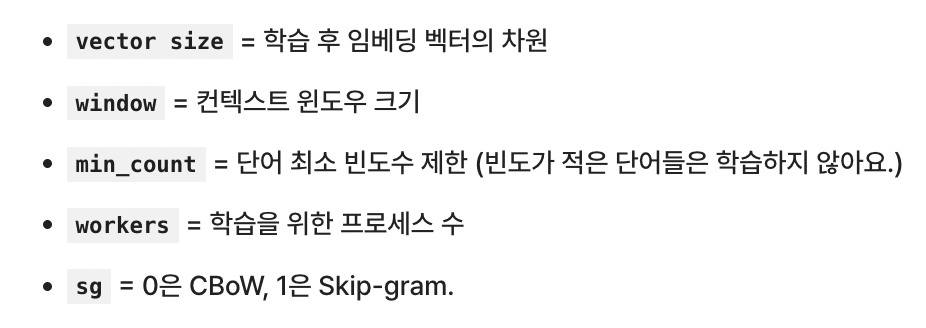

In [7]:
# 입력한 단어에 대해서 가장 코사인 유사도가 높은 단어들을 출력하는 
# model.wv.most_similar를 지원 

model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.9233373999595642), ('skull', 0.911032497882843), ('Bang', 0.9056490063667297), ('asteroid', 0.9051957130432129), ('third', 0.9020178318023682), ('baby', 0.8993921279907227), ('dog', 0.8985978364944458), ('bought', 0.8975234031677246), ('rally', 0.8912491798400879), ('disc', 0.8888981342315674)]


skull > 두개골...? 
도대체 저 단어들의 어느부분이 유사도가 높은지 아직은 모르겠다.

In [8]:
# 모델을 저장하고 로드하는 방법 

from gensim.models import KeyedVectors

model.wv.save_word2vec_format('~/aiffel/word_embedding/w2v') 
loaded_model = KeyedVectors.load_word2vec_format("~/aiffel/word_embedding/w2v")

In [9]:
# 로드한 모델이 이전과 동일한 결과를 출력하는지 테스트
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.9233373999595642), ('skull', 0.911032497882843), ('Bang', 0.9056490063667297), ('asteroid', 0.9051957130432129), ('third', 0.9020178318023682), ('baby', 0.8993921279907227), ('dog', 0.8985978364944458), ('bought', 0.8975234031677246), ('rally', 0.8912491798400879), ('disc', 0.8888981342315674)]


### Word2Vec의 OOV 문제

In [10]:
# 에러가 나더라도 놀라지 마세요.
loaded_model.most_similar('overacting')

KeyError: "Key 'overacting' not present"

훈련 데이터에 없는 단어는 에러를 발생 시킨다.

In [11]:
# 오타가 발생했을 경우 
loaded_model.most_similar('memorry')

KeyError: "Key 'memorry' not present"

## 임베딩 벡터의 시각화
- 임베딩 프로젝터(embedding projector)를 사용해서 임베딩 벡터 시각화 
- 어떤 임베딩 벡터들이 가까운 거리에 군집이 되어 있고, 특정 임베딩 벡터와 유클리드 거리나 코사인 유사도가 높은지 확인할 수 있다.

### 필요한 파일 만들기
https://radimrehurek.com/gensim/models/word2vec.html

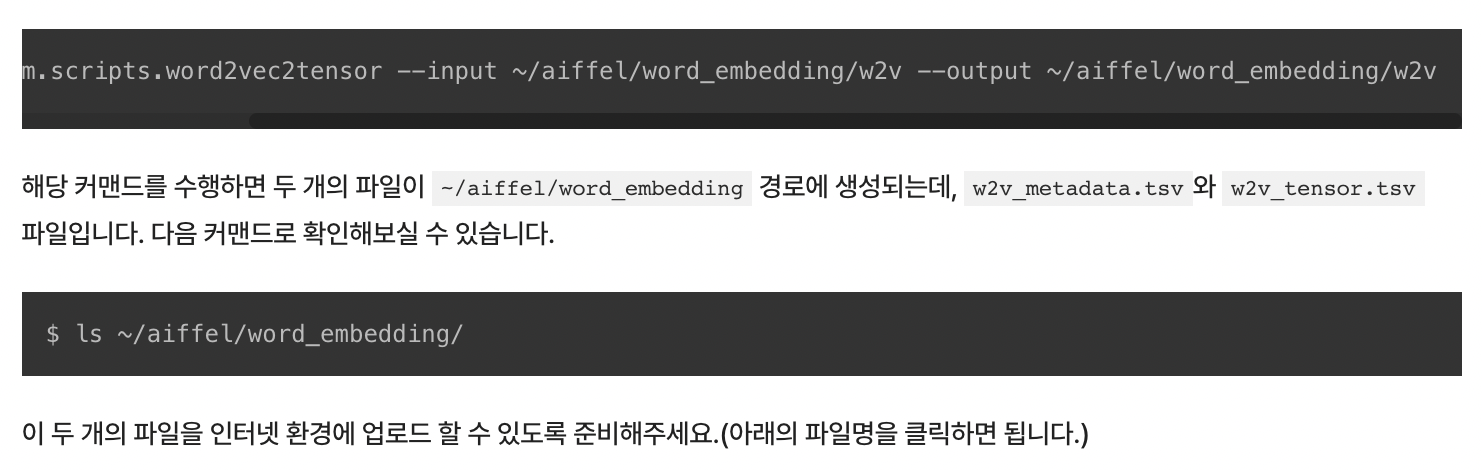

1. python -m gensim.scripts.word2vec2tensor --input ~/aiffel/word_embedding/w2v --output ~/aiffel/word_embedding/w2v

2. ls ~/aiffel/word_embedding/


### 임베딩 프로젝터에 tsv 파일 업로드하기
https://projector.tensorflow.org/

## FastText

### FastText의 학습 방법
- 학습 과정에서 중심 단어에 속한 문자 단위 n-gram 단어 벡터들을 모두 업데이트한다. 

### OOV와 오타에 대한 대응

In [12]:
from gensim.models import FastText
fasttext_model = FastText(corpus, window=5, min_count=5, workers=4, sg=1)

In [13]:
fasttext_model.wv.most_similar('overacting')

[('extracting', 0.9326014518737793),
 ('emptying', 0.9303713440895081),
 ('fluctuating', 0.9285447597503662),
 ('overwhelming', 0.9282910227775574),
 ('resolving', 0.9279713034629822),
 ('declining', 0.9264652132987976),
 ('lifting', 0.9254626035690308),
 ('hunting', 0.924763560295105),
 ('attracting', 0.9244491457939148),
 ('tasting', 0.9243146181106567)]

In [14]:
fasttext_model.wv.most_similar('memoryy')

[('memory', 0.9485412836074829),
 ('basic', 0.8633842468261719),
 ('musical', 0.862424910068512),
 ('mechanism', 0.8541094660758972),
 ('intelligence', 0.8520154356956482),
 ('mechanisms', 0.8460342884063721),
 ('video', 0.8367882966995239),
 ('emotion', 0.8355449438095093),
 ('music', 0.8318546414375305),
 ('mess', 0.8292459845542908)]

### pre-trained GloVe 모델 실습

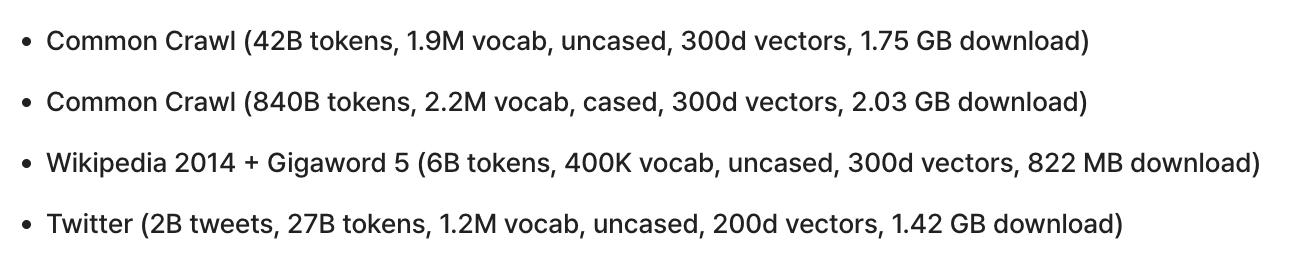

In [15]:
import gensim.downloader as api
glove_model = api.load("glove-wiki-gigaword-50")  # glove vectors 다운로드
glove_model.most_similar("dog")  # 'dog'과 비슷한 단어 찾기

[==============================================----] 93.9% 62.0/66.0MB downloaded

[('cat', 0.9218004941940308),
 ('dogs', 0.8513158559799194),
 ('horse', 0.7907583713531494),
 ('puppy', 0.7754920721054077),
 ('pet', 0.7724708318710327),
 ('rabbit', 0.7720814347267151),
 ('pig', 0.7490062117576599),
 ('snake', 0.7399188876152039),
 ('baby', 0.7395570278167725),
 ('bite', 0.7387937307357788)]

In [16]:
glove_model.most_similar('overacting')

[('impudence', 0.7842012047767639),
 ('puerile', 0.7816032767295837),
 ('winningly', 0.7644237875938416),
 ('grossness', 0.7576098442077637),
 ('deconstructions', 0.748936653137207),
 ('over-the-top', 0.7460805773735046),
 ('buffoonery', 0.746045708656311),
 ('impetuosity', 0.7415392398834229),
 ('sophomoric', 0.736961841583252),
 ('zaniness', 0.7353197336196899)]

In [17]:
glove_model.most_similar('memoryy')

KeyError: "Key 'memoryy' not present"

1. GloVe도 OOV 문제를 갖고 있다. 
2. pre-trained GloVe모델은 한글이나 알파벳 대문자가 포함된 데이터셋으로 학습하지 않았기 때문에 알파벳 소문자만 인식한다.